# GEOG5990M Final Assignment

Student ID number: 201896942

房价数据——有邮编

小邮编区的住房中心点数据

LSoa数据

思路：

对于房价数据，使用邮编字段进行链接

Lsoa数据使用字段筛选出属于大都会区的所有lsoa

本研究致力于使用曼彻斯特大都会地区的房价数据以及各房产的交通可达性数据来探索房屋售价

In [ ]:
# import required packages
# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data manipulation
import pandas as pd
import numpy as np

# import any further required packages
!pip install contextily
!pip install geoplot
!pip install git+https://github.com/pmdscully/geo_northarrow.git

import geopandas as gpd
import pyproj
import contextily as ctx

import geoplot as gplt
import geoplot.crs as gcrs
from geo_northarrow import add_north_arrow
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

首先加载房价数据

数据来源于：Statistical data set

Price Paid Data

https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#march-2025-data-current-month

为2025年1-3月全英所有成交的房屋记录


下一步进行数据加载，首先加载房价数据然后显示前5行来观察数据的构成

In [2]:
from google.colab import drive
# 步骤2: 挂载Google Drive
drive.mount('/content/drive')
hpall = pd.read_csv('/content/drive/MyDrive/Python_final/pp-2025.csv')
hpall.head()

Mounted at /content/drive


Transaction unique identifier   Price Date of Transfer  Postcode  \
0  {31C68072-988E-FEE3-E063-4804A8C04F37}  320000   2025/2/28 0:00  KT20 5SJ   
1  {31C68072-988F-FEE3-E063-4804A8C04F37}  423500   2025/2/14 0:00   RH1 3LS   
2  {31C68072-9891-FEE3-E063-4804A8C04F37}  525000   2025/2/13 0:00  GU18 5AA   
3  {31C68072-9892-FEE3-E063-4804A8C04F37}  845000   2025/3/24 0:00   RH1 4JA   
4  {31C68072-9893-FEE3-E063-4804A8C04F37}  225000   2025/2/24 0:00  GU15 2EH   

  Property Type Old/New Duration               PAON    SAON  \
0             F       N        L                 21     NaN   
1             S       N        F                 36     NaN   
2             D       N        F                 20     NaN   
3             D       N        F     NUTFIELD COURT       2   
4             F       N        L  BENTLEY COURT, 33  FLAT 3   

              Street  Locality   Town/City              District  County  \
0  CORNER FARM CLOSE       NaN    TADWORTH  REIGATE AND BANSTEAD  SURREY   
1        ALBURY ROAD  MERSTHAM     REDHILL  REIGATE AND BANSTEAD  SURREY   
2     CONISTON COURT       NaN  LIGHTWATER          SURREY HEATH  SURREY   
3        CHURCH HILL  NUTFIELD     REDHILL             TANDRIDGE  SURREY   
4  UPPER GORDON ROAD       NaN   CAMBERLEY          SURREY HEATH  SURREY   

  PPD Category Type Record Status  
0                 A             A  
1                 A             A  
2                 A             A  
3                 A             A  
4                 A             A

可以观察到对于此项目研究的课题，其中有很多冗余信息

首先要使用county字段筛选出man内的房屋交易数据，然后去掉多余字段，只保留房价、邮编以及一些房产参数。而且观察到房产交易信息中并不包含空间数据。跟较为准确的地理位置相关的信息只有邮编，因此后续需要进一步通过邮编数据来为房价信息增加空间属性。

In [ ]:
#hpall.info()
#hpall.describe()

从
https://osdatahub.os.uk/downloads/open/CodePointOpen
搜集到了不同的邮编对应的坐标点的数据
对于标有PQI(定位质量指标)为10的邮政编码，其"中心点"是通过以下算法计算的：首先，计算该邮政编码单元内所有地址的坐标平均值，获得一个平均位置；然后，该邮政编码的中心点坐标被设定为该邮政编码单元内最接近这个平均位置的实际地址的坐标。
对于您的研究来说，这个数据非常适合，因为它确实提供了每个邮政编码区域的中心点坐标，而不仅仅是一个粗略的位置。这意味着您可以利用这些数据点计算到最近公共交通站点的距离，获得相对准确的可达性测量。
您需要注意的是，虽然这些中心点非常精确，但它们并不一定是邮政编码区域的几何中心，而是基于该区域内实际地址分布计算出的点。这对您的研究实际上是有利的，因为它们更好地代表了人们实际居住的位置。



In [3]:
#加载邮编坐标点数据postcode position
pcptall = gpd.read_file('/content/drive/MyDrive/Python_final/codepo_gb.gpkg')

# 读取Shapefile
lsoa_all = gpd.read_file('/content/drive/MyDrive/Python_final/BoundaryData/england_lsoa_2021.shp')

In [4]:
#筛选man的lsoa
# 定义大曼彻斯特的所有地区名称
gm_areas = ['Manchester', 'Salford', 'Bolton', 'Bury', 'Oldham',
            'Rochdale', 'Stockport', 'Tameside', 'Trafford', 'Wigan']

# 一行完成筛选 - 使用str.startswith搭配元组参数
gm_lsoa = lsoa_all[lsoa_all['lsoa21nm'].str.startswith(tuple(gm_areas))]

In [7]:
pcptall.head()

postcode  positional_quality_indicator country_code nhs_regional_ha_code  \
0  AL1 1AG                            10    E92000001            E19000001   
1  AL1 1AJ                            10    E92000001            E19000001   
2  AL1 1AR                            10    E92000001            E19000001   
3  AL1 1AS                            10    E92000001            E19000001   
4  AL1 1AT                            10    E92000001            E19000001   

  nhs_ha_code admin_county_code admin_district_code admin_ward_code  \
0   E18000006         E10000015           E07000240       E05013963   
1   E18000006         E10000015           E07000240       E05013963   
2   E18000006         E10000015           E07000240       E05013951   
3   E18000006         E10000015           E07000240       E05013964   
4   E18000006         E10000015           E07000240       E05013951   

                geometry  
0  POINT (515487 206498)  
1  POINT (515491 206410)  
2  POINT (516270 205897)  
3  POINT (515005 206908)  
4  POINT (516131 206148)

In [6]:
gm_lsoa.head()

lsoa21cd     lsoa21nm                                          label  \
0   E01004785  Bolton 006B  E92000001E12000002E08000001E02000989E01004785   
20  E01005443  Oldham 003B  E92000001E12000002E08000004E02001100E01005443   
21  E01006380   Wigan 029D  E92000001E12000002E08000010E02001315E01006380   
22  E01005434  Oldham 024B  E92000001E12000002E08000004E02001121E01005434   
24  E01005007    Bury 019D  E92000001E12000002E08000002E02001037E01005007   

           name                                           geometry  
0   Bolton 006B  POLYGON ((374304.608 411531.913, 374306.625 41...  
20  Oldham 003B  POLYGON ((394102.25 411199.249, 394108.5 41119...  
21   Wigan 029D  POLYGON ((371555.967 402040.5, 371552.615 4020...  
22  Oldham 024B  POLYGON ((392889.653 405054.093, 392893.478 40...  
24    Bury 019D  POLYGON ((380549.366 406758.315, 380543.792 40...

In [5]:
print(f"邮编点数据CRS: {pcptall.crs}")
print(f"LSOA数据CRS: {gm_lsoa.crs}")
# 只保留LSOA数据中的必要字段，减少内存使用
postcode_simple = pcptall[['postcode', 'geometry', 'positional_quality_indicator']].copy()
lsoa_simple = gm_lsoa[['lsoa21cd', 'lsoa21nm', 'geometry']].copy()
pc_man = gpd.sjoin(
    postcode_simple,              # 左侧数据集 - 邮编点
    lsoa_simple,          # 右侧数据集 - LSOA边界
    how="inner",          # 内连接 - 只保留位于LSOA内的点
    predicate="intersects"    # 空间关系 - 点必须在多边形内
)

pc_man.head()

邮编点数据CRS: EPSG:27700
LSOA数据CRS: EPSG:27700


postcode               geometry  positional_quality_indicator  \
113456  BL0 0AA  POINT (379448 416851)                            10   
113457  BL0 0AB  POINT (379442 416877)                            10   
113458  BL0 0AD  POINT (379389 417007)                            10   
113460  BL0 0AG  POINT (379627 416803)                            10   
113461  BL0 0AH  POINT (379409 417016)                            10   

        index_right   lsoa21cd   lsoa21nm  
113456         3636  E01005014  Bury 001A  
113457         3636  E01005014  Bury 001A  
113458         3636  E01005014  Bury 001A  
113460         3764  E01005017  Bury 001D  
113461         3636  E01005014  Bury 001A

In [6]:

# 步骤2: 将邮编点数据转换为GeoDataFrame
postcode_gdf = gpd.GeoDataFrame(pc_man, geometry='geometry')

# 步骤3: 处理邮编格式，确保匹配一致性
# 去除可能存在的空格以便匹配
postcode_gdf['postcode_clean'] = postcode_gdf['postcode'].str.replace(' ', '')
hpall['postcode_clean'] = hpall['Postcode'].str.replace(' ', '')
# 如果hpall中也有geometry列，先重命名避免冲突
if 'geometry' in hpall.columns:
    hpall = hpall.rename(columns={'geometry': 'geometry_original'})

# 然后进行合并
merged_data = pd.merge(
    hpall,
    postcode_gdf[['postcode_clean', 'geometry', 'lsoa21nm', 'lsoa21cd']],
    on='postcode_clean',
    how='left'
)

merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
hp_man = merged_data[merged_data.geometry.notna()].copy()
hp_man.info()
hp_man.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4566 entries, 2741 to 104129
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Transaction unique identifier  4566 non-null   object  
 1   Price                          4566 non-null   int64   
 2   Date of Transfer               4566 non-null   object  
 3   Postcode                       4566 non-null   object  
 4   Property Type                  4566 non-null   object  
 5   Old/New                        4566 non-null   object  
 6   Duration                       4566 non-null   object  
 7   PAON                           4566 non-null   object  
 8   SAON                           468 non-null    object  
 9   Street                         4566 non-null   object  
 10  Locality                       2124 non-null   object  
 11  Town/City                      4566 non-null   object  
 12  District                  

Transaction unique identifier   Price Date of Transfer  \
2741  {31C68072-35D3-FEE3-E063-4804A8C04F37}  240000   2025/2/28 0:00   
2754  {31C68072-35E4-FEE3-E063-4804A8C04F37}  224550   2025/2/14 0:00   
3129  {31C68072-32D8-FEE3-E063-4804A8C04F37}  138000   2025/3/24 0:00   
3130  {31C68072-32DA-FEE3-E063-4804A8C04F37}  244999   2025/2/28 0:00   
3132  {31C68072-32DC-FEE3-E063-4804A8C04F37}   51000   2025/2/13 0:00   

      Postcode Property Type Old/New Duration  PAON SAON              Street  \
2741   M19 3HU             T       N        F     2  NaN     FAIRBOURNE ROAD   
2754    M6 7WG             T       N        F    10  NaN    STAPLETON STREET   
3129  OL11 4NA             T       N        L    19  NaN  WESTMINSTER STREET   
3130   BL3 4RT             D       N        L     8  NaN    CHESTERTON DRIVE   
3132   M43 7AA             F       N        F  154A  NaN       MARKET STREET   

       Locality   Town/City    District              County PPD Category Type  \
2741        NaN  MANCHESTER  MANCHESTER  GREATER MANCHESTER                 A   
2754        NaN     SALFORD     SALFORD  GREATER MANCHESTER                 A   
3129        NaN    ROCHDALE    ROCHDALE  GREATER MANCHESTER                 A   
3130        NaN      BOLTON      BOLTON  GREATER MANCHESTER                 A   
3132  DROYLSDEN  MANCHESTER    TAMESIDE  GREATER MANCHESTER                 A   

     Record Status postcode_clean               geometry         lsoa21nm  \
2741             A         M193HU  POINT (388204 394214)  Manchester 064A   
2754             A          M67WG  POINT (379402 400496)     Salford 018A   
3129             A        OL114NA  POINT (388769 412084)    Rochdale 010A   
3130             A         BL34RT  POINT (368276 408365)      Bolton 020A   
3132             A         M437AA  POINT (390483 398186)    Tameside 010E   

       lsoa21cd  
2741  E01005200  
2754  E01005622  
3129  E01005472  
3130  E01004835  
3132  E01006000

In [7]:
hp_man = hp_man.drop(['Transaction unique identifier', 'Date of Transfer', 'PAON', 'SAON', 'Locality', 'Street', 'PPD Category Type', 'Record Status', 'postcode_clean'], axis=1)
hp_man.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4566 entries, 2741 to 104129
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Price          4566 non-null   int64   
 1   Postcode       4566 non-null   object  
 2   Property Type  4566 non-null   object  
 3   Old/New        4566 non-null   object  
 4   Duration       4566 non-null   object  
 5   Town/City      4566 non-null   object  
 6   District       4566 non-null   object  
 7   County         4566 non-null   object  
 8   geometry       4566 non-null   geometry
 9   lsoa21nm       4566 non-null   object  
 10  lsoa21cd       4566 non-null   object  
dtypes: geometry(1), int64(1), object(9)
memory usage: 557.1+ KB


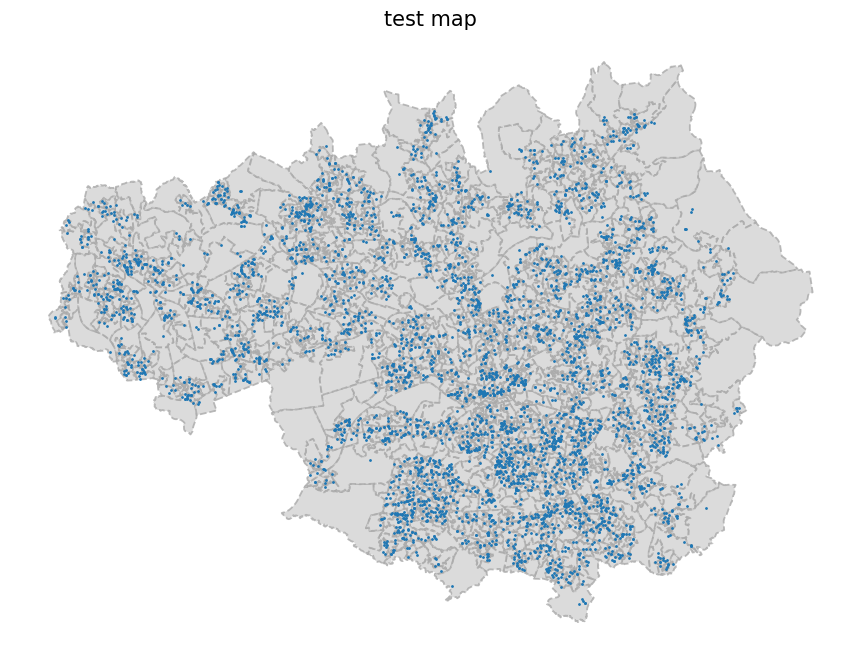

In [9]:
#house price data test visualization
f, ax = plt.subplots(1, figsize=(16, 8))
# define the basemap plot it on the sublot axis
base = gm_lsoa.plot(ax=ax,facecolor='lightgrey',alpha=0.8,
                         edgecolor='darkgrey',          # set border color
                         linewidth=1.3,              # set border length
                         linestyle='dashed')          # set border style

# plot the house location on the basemap axis, colour the location points by their saling price
hp_man.plot(ax=base,
             markersize=1,
             legend=False,
             )
# remove axis
ax.set_axis_off()
# add title
ax.set_title('test map', fontsize=15)
# show the map
plt.show()

根据可视化效果进行验证，可以看到Manchester的lsoa边界已经正确的裁切，房价数据点也均匀分布在Manchester区域内，进行到这里房屋的地理位置数据以及对应的房屋价格数据已经准备完毕，Manchester的losa边界也已完全处理完毕

下一步开始处理公交站点数据

In [8]:
pbtsp_all = pd.read_csv('/content/drive/MyDrive/Python_final/Stops.csv')
pbtsp_all.info()

<ipython-input-8-964e0fc6bc8c>:1: DtypeWarning: Columns (1,2,6,8,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  pbtsp_all = pd.read_csv('/content/drive/MyDrive/Python_final/Stops.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433259 entries, 0 to 433258
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ATCOCode                 433259 non-null  object 
 1   NaptanCode               407498 non-null  object 
 2   PlateCode                62892 non-null   object 
 3   CleardownCode            0 non-null       float64
 4   CommonName               433259 non-null  object 
 5   CommonNameLang           0 non-null       float64
 6   ShortCommonName          96576 non-null   object 
 7   ShortCommonNameLang      0 non-null       float64
 8   Landmark                 249347 non-null  object 
 9   LandmarkLang             0 non-null       float64
 10  Street                   409122 non-null  object 
 11  StreetLang               0 non-null       float64
 12  Crossing                 0 non-null       float64
 13  CrossingLang             0 non-null       float64
 14  Indi

根据info信息显示，公交数据存在很多字段，由于数据太长以至于不能在colab中完整显示，因此在excel中打开，使用二者相结合着进行了观察

因为字段过多，在保证建模必要字段的基础上应尽可能精简数据，经过对字段进行分析保留以下字段并标注对应原因

1.CommonName - 每个站点独有的名称，用来后续对数据做标识

2.Easting, Northing - national grid 坐标，观察上面info信息可知经纬度信息存在大量null值，为保证数据完整性选择国家网格坐标来生成地理数据

3.StopType - 最重要的字段之一，代表了公交站点的类型，包括机场，火车站，公交站点等，对后续建模赋予权重有重要参考意义

4.Modification - The NaPTAN dataset is updated when information is provided by staff based throughout local authorities around the UK. 该字段为delete的值为无效数据，应当删掉

5.Status - 标识了当前公交站点的使用状况，inactive的为无效数据，应当删去

以上1/4/5用于清洗数据，2/3用于为后续创建地理数据提供关键参数

In [9]:
# 1. 首先进行数据清洗 - 保留需要的字段并删除无效数据
# 只保留需要的字段
pbtsp_cleaned = pbtsp_all[['CommonName', 'Easting', 'Northing', 'StopType', 'Modification', 'Status']]

# 移除无效数据 - Status为inactive的站点
pbtsp_cleaned = pbtsp_cleaned[pbtsp_cleaned['Status'] == 'active']

# 移除无效数据 - Modification为delete的站点
pbtsp_cleaned = pbtsp_cleaned[pbtsp_cleaned['Modification'] != 'delete']

# 确保有网格坐标数据
pbtsp_cleaned = pbtsp_cleaned.dropna(subset=['Easting', 'Northing'])

# 2. 直接使用网格坐标创建GeoDataFrame
pbtsp_gdf = gpd.GeoDataFrame(
    pbtsp_cleaned,
    geometry=gpd.points_from_xy(pbtsp_cleaned.Easting, pbtsp_cleaned.Northing),
    crs="EPSG:27700"  # British National Grid
)

# 3. 确保gm_lsoa和pbtsp_gdf使用相同的坐标系
if gm_lsoa.crs != "EPSG:27700":
    gm_lsoa = gm_lsoa.to_crs("EPSG:27700")

# 4. 检查gm_lsoa的范围
print("LSOA边界范围:", gm_lsoa.total_bounds)

# 5. 创建曼彻斯特区域边界
manchester_boundary = gm_lsoa.unary_union
# 添加小缓冲区以包含边界附近的站点（1000米）
manchester_buffer = manchester_boundary.buffer(1000)

# 6. 先进行空间筛选
# 只保留曼彻斯特区域内的站点
stops_in_manchester = pbtsp_gdf[pbtsp_gdf.geometry.intersects(manchester_buffer)]
print(f"曼彻斯特区域内的站点数量: {len(stops_in_manchester)}")

# 7. 然后筛选站点类型
selected_types = ['AIR', 'RLY', 'TMU', 'BST', 'BCT']
final_stops = stops_in_manchester[stops_in_manchester['StopType'].isin(selected_types)]

# 8. 检查筛选结果
print(f"筛选后站点数量: {len(final_stops)}")
print("按站点类型统计:")
print(final_stops['StopType'].value_counts())


final_stops.info()

LSOA边界范围: [351662.3426 381166.044  406087.19   421037.687 ]


<ipython-input-9-02bf95fd5441>:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  manchester_boundary = gm_lsoa.unary_union


曼彻斯特区域内的站点数量: 15860
筛选后站点数量: 14979
按站点类型统计:
StopType
BCT    14585
TMU      264
RLY       99
BST       23
AIR        8
Name: count, dtype: int64
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 14979 entries, 27136 to 429712
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CommonName    14979 non-null  object  
 1   Easting       14979 non-null  int64   
 2   Northing      14979 non-null  int64   
 3   StopType      14979 non-null  object  
 4   Modification  14979 non-null  object  
 5   Status        14979 non-null  object  
 6   geometry      14979 non-null  geometry
dtypes: geometry(1), int64(2), object(4)
memory usage: 936.2+ KB


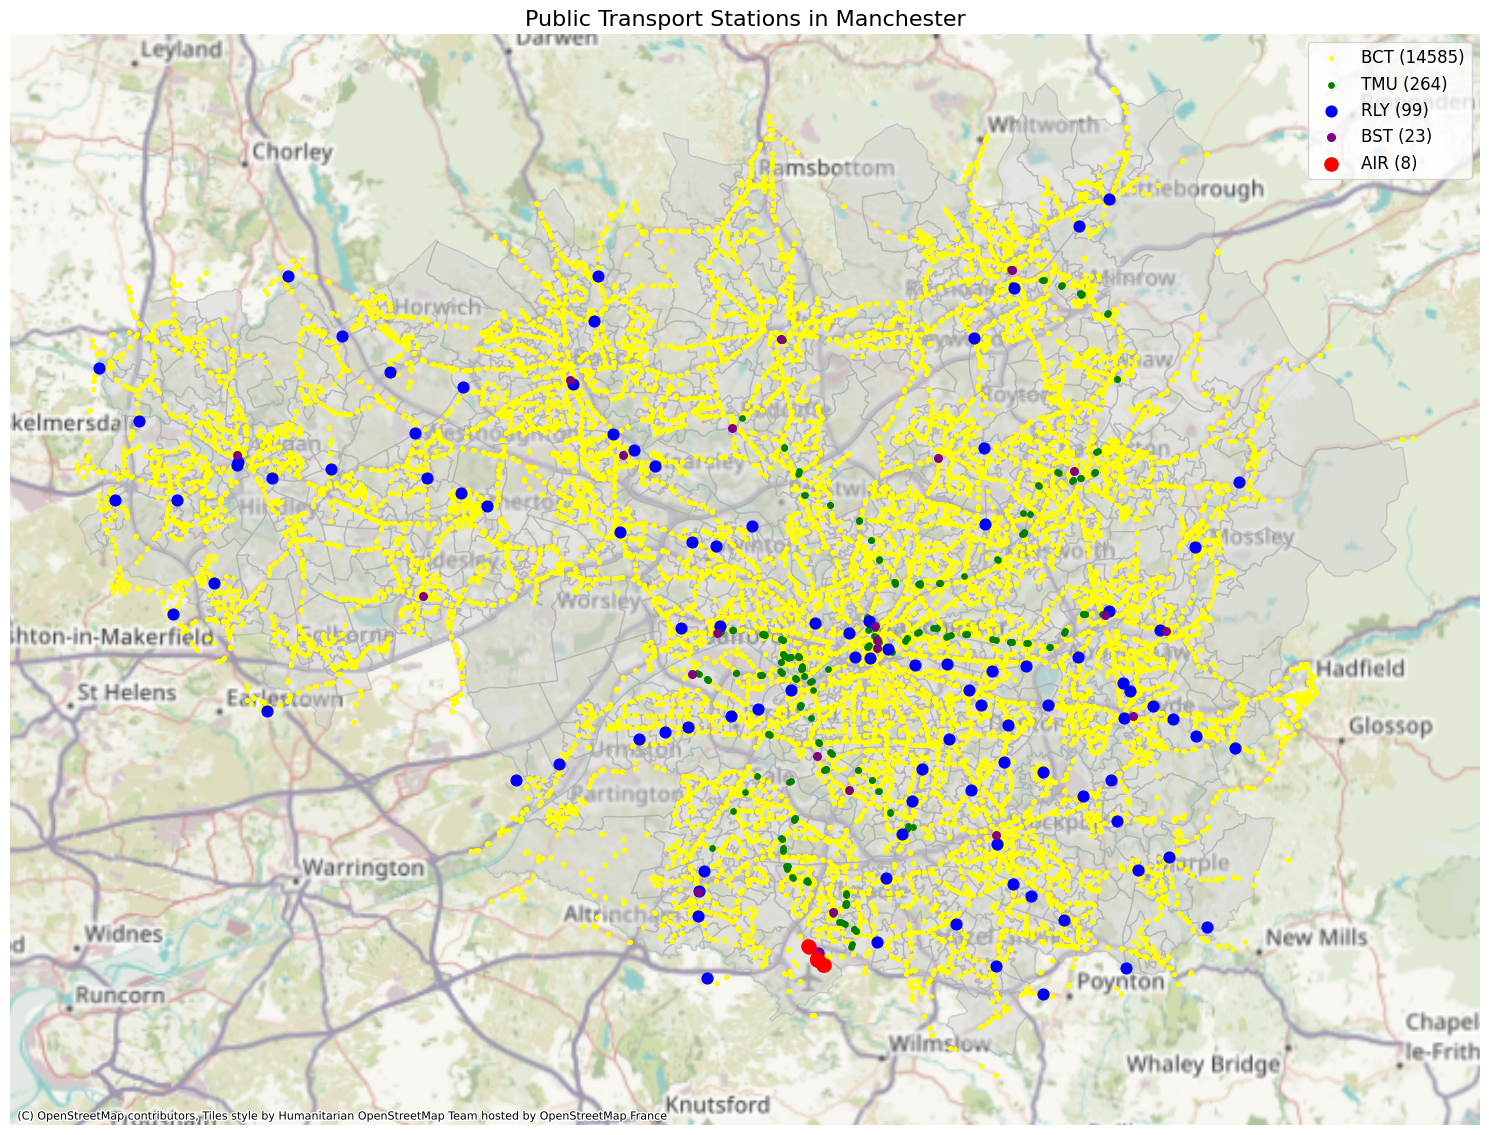

In [13]:
# 创建图形
fig, ax = plt.subplots(1, figsize=(15, 12))

# 设置颜色映射
colors = {'BCT': 'yellow','TMU': 'green','RLY': 'blue','BST': 'purple','AIR': 'red'}
#'BCT': 'yellow','TMU': 'green','RLY': 'blue','BST': 'purple','AIR': 'red'

# 绘制LSOA边界作为底图
gm_lsoa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)

# 按站点类型分组并绘制
for stop_type, color in colors.items():
    if stop_type in final_stops['StopType'].values:
        subset = final_stops[final_stops['StopType'] == stop_type]
        subset.plot(ax=ax, color=color, marker='o',
                   label=f"{stop_type} ({len(subset)})",
                   markersize=90 if stop_type == 'AIR' else
                              60 if stop_type == 'RLY' else
                              15 if stop_type == 'TMU' else
                              30 if stop_type == 'BST' else 7)

ctx.add_basemap(ax, crs=gm_lsoa.crs.to_string())

# 添加图例和标题
ax.legend(fontsize=12)
ax.set_title('Public Transport Stations in Manchester', fontsize=16)
ax.set_axis_off()

# 显示图形
plt.tight_layout()
plt.show()

在经过对公交站点的数据整理以及可视化之后，观察到公交站点点位均匀地分布于整个Manchester大都会区域，且符合路网的分布模式，说明数据的导入与清理获得了成功

然而，在分类数据中可以看到机场有8个点位，经过查询Manchester只有一个机场，因此使用commonname字段输出数据观察为何出现这种情况

In [30]:
# 筛选出StopType为'AIR'的站点
air_stops = final_stops[final_stops['StopType'] == 'AIR']
display(air_stops['CommonName'])

14971    Manchester Airport
Name: CommonName, dtype: object

可以观察到，这八个air type的点并不都是机场，而是指代不同的航站楼入口，为避免对后续建模造成错误影响，需要将八个点合并为一个点

In [11]:
# 2. 筛选出机场站点
airport_terminals = final_stops[final_stops['StopType'] == 'AIR']
print(f"原始机场站点数量: {len(airport_terminals)}")

# 3. 计算机场站点的中心点
airport_center = airport_terminals.geometry.unary_union.centroid

# 4. 从数据中移除所有机场站点
final_stops = final_stops[final_stops['StopType'] != 'AIR']

# 5. 创建新的机场中心点记录
# 获取原始数据的列，以确保新记录有相同的列结构
columns = final_stops.columns.tolist()

# 创建新的机场记录，根据列结构填充数据
new_airport = {}
for col in columns:
    if col == 'CommonName':
        new_airport[col] = 'Manchester Airport'
    elif col == 'StopType':
        new_airport[col] = 'AIR'
    elif col == 'geometry':
        continue  # geometry将通过GeoDataFrame构造函数添加
    else:
        # 对其他列使用默认值或从原始机场数据中获取值
        if len(airport_terminals) > 0 and col in airport_terminals.columns:
            new_airport[col] = airport_terminals.iloc[0][col]
        else:
            new_airport[col] = None

# 创建新的机场中心点GeoDataFrame
airport_point = gpd.GeoDataFrame([new_airport], geometry=[airport_center], crs=final_stops.crs)

# 6. 将新的机场点添加到原始数据中
final_stops = pd.concat([final_stops, airport_point])

# 7. 重置索引
final_stops = final_stops.reset_index(drop=True)

原始机场站点数量: 8


<ipython-input-11-fab7f10cde1c>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  airport_center = airport_terminals.geometry.unary_union.centroid


In [12]:
print(final_stops['StopType'].value_counts())

StopType
BCT    14585
TMU      264
RLY       99
BST       23
AIR        1
Name: count, dtype: int64


可以观察到机场航站楼已被取中心值为一个，至此数据的导入、清理、筛选，全部完成，下一步开始建模

##建模

对于本研究，如何选择合适的数据对每个房屋的公共交通可达性进行量化是一个难点，在考虑到点位的房价数据与公交类别数据之间的关系离不开他们之间的地理关系，故选择gwr模型对这两个变量进行建模

In [37]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# 1. 数据准备：从geometry中提取x和y坐标
hp_man['x'] = hp_man.geometry.x
hp_man['y'] = hp_man.geometry.y
final_stops['x'] = final_stops.geometry.x
final_stops['y'] = final_stops.geometry.y

权重分析

In [54]:
# 2. 根据站点类型分配权重
# 创建站点类型权重字典 - 您可以根据理论基础或先验知识调整这些权重
stop_type_weights = {
    'BCT': 0.5,      # 公交站点
    'BST': 1.0,      # 公交站点
    'TMU': 1.5,      # 地铁站
    'RLY': 3.0,      # 火车站
    'AIR': 5.0,      # 机场
    # 添加其他站点类型及其权重
}

# 将权重添加到final_stops数据框
final_stops['weight'] = final_stops['StopType'].map(lambda x: stop_type_weights.get(x, 1.0))

An essential element in modeling access to transit stops is the distance that people walk to get to a stop. Researchers have typically used walking distances similar to planners’ rule of thumb of 400 m (0.25 mile) and 800 m (0.5 mile) for estimating the distance people will walk to a transit stop or station (El-Geneidy et al., 2009, Hess, 2009, Hsiao et al., 1997, Kimpel et al., 2007, Lovett et al., 2002)

Assessing Transport Connectivity in London. Transport for London也证实在伦敦人们The calculation assumes that people will walk up to 640 metres
(approximately eight minutes) to a bus service and up to 960 metres
(12 minutes) to a rail or Tube service. （网站引用）

In [55]:
# 3. 为每个房价点添加加权公交可达性特征
stop_type_weights
def add_transit_features_weighted(hp_df, stops_df, buffer_distances=[400, 800]):
    """计算考虑站点类型权重的公交可达性指标"""
    # 构建KD树
    stops_coords = stops_df[['x', 'y']].values
    tree = KDTree(stops_coords)

    # 计算每个房价点到最近公交站点的距离和类型
    house_coords = hp_df[['x', 'y']].values
    distances, indices = tree.query(house_coords, k=1)
    hp_df['nearest_stop_dist'] = distances.flatten()

    # 添加最近站点类型及其权重
    hp_df['nearest_stop_type'] = stops_df.iloc[indices.flatten()]['StopType'].values
    hp_df['nearest_stop_weight'] = stops_df.iloc[indices.flatten()]['weight'].values

    # 计算加权距离（距离除以权重，使重要站点的"有效距离"更短）
    hp_df['weighted_nearest_dist'] = hp_df['nearest_stop_dist'] / hp_df['nearest_stop_weight']

    # 检查实际存在的站点类型
    existing_stop_types = stops_df['StopType'].unique()
    print("数据中存在的站点类型:", existing_stop_types)

    # 计算缓冲区内的加权站点指标
    for dist in buffer_distances:
        # 普通计数
        counts = []
        # 加权计数
        weighted_counts = []

        # 按站点类型的计数
        type_counts = {}
        for type_key in existing_stop_types:  # 只对实际存在的类型进行计数
            type_counts[f'stops_{type_key}_within_{dist}m'] = []

        for idx, coord in enumerate(house_coords):
            # 找出缓冲区内的所有站点
            idx_array = tree.query_radius([coord], r=dist)[0]

            # 计算普通计数
            counts.append(len(idx_array))

            # 计算加权计数
            if len(idx_array) > 0:
                stop_weights = stops_df.iloc[idx_array]['weight'].values
                weighted_counts.append(np.sum(stop_weights))
            else:
                weighted_counts.append(0)

            # 按站点类型计数
            for type_key in existing_stop_types:
                if len(idx_array) > 0:
                    type_mask = stops_df.iloc[idx_array]['StopType'] == type_key
                    type_count = np.sum(type_mask)
                else:
                    type_count = 0
                type_counts[f'stops_{type_key}_within_{dist}m'].append(type_count)

        # 添加到数据框
        hp_df[f'stops_within_{dist}m'] = counts
        hp_df[f'weighted_stops_within_{dist}m'] = weighted_counts

        # 添加按类型的计数
        for type_key, type_count_list in type_counts.items():
            hp_df[type_key] = type_count_list

    return hp_df

# 应用特征提取
hp_man_with_features = add_transit_features_weighted(hp_man.copy(), final_stops)

# 4. 移动窗口回归分析 - 完全重写以确保一致性
def moving_window_regression(df, x_vars, y_var, coords_cols=['x', 'y'], window_size=200):
    """使用移动窗口进行局部回归分析"""
    n_points = len(df)
    n_vars = len(x_vars)

    # 预先创建固定大小的结果数组
    window_x = np.full(n_points, np.nan)
    window_y = np.full(n_points, np.nan)
    r2_values = np.full(n_points, np.nan)

    # 为每个变量创建系数和显著性数组
    coef_arrays = {f'coef_{var}': np.full(n_points, np.nan) for var in x_vars}
    sig_arrays = {f'sig_{var}': np.full(n_points, np.nan) for var in x_vars}

    # 提取坐标
    coords = df[coords_cols].values

    # 找到每个点的邻居
    print("计算空间邻居...")
    tree = KDTree(coords)
    _, neighbors = tree.query(coords, k=window_size+1)

    # 标准化特征
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[x_vars] = scaler.fit_transform(df[x_vars])

    # 对每个点进行局部回归
    print(f"运行{n_points}个局部回归...")
    for i in range(n_points):
        if i % 500 == 0:
            print(f"处理第{i}个点，共{n_points}个")

        # 记录坐标
        window_x[i] = df[coords_cols[0]].iloc[i]
        window_y[i] = df[coords_cols[1]].iloc[i]

        # 获取邻居的索引
        neighbor_indices = neighbors[i, 1:]  # 排除自身

        # 检查是否有足够的邻居
        if len(neighbor_indices) <= n_vars + 1:
            # 邻居太少，无法拟合模型，跳过
            continue

        # 提取局部数据
        local_X = df_scaled.iloc[neighbor_indices][x_vars]
        local_y = df_scaled.iloc[neighbor_indices][y_var]

        try:
            # 运行OLS回归
            X_with_const = sm.add_constant(local_X)
            model = sm.OLS(local_y, X_with_const)
            reg_results = model.fit()

            # 记录结果
            r2_values[i] = reg_results.rsquared

            for j, var in enumerate(x_vars):
                coef_arrays[f'coef_{var}'][i] = reg_results.params[j+1]  # +1跳过常数项
                sig_arrays[f'sig_{var}'][i] = reg_results.pvalues[j+1] < 0.05

        except Exception as e:
            # 只在有意外错误时输出
            if not str(e).startswith('index') and not 'out of bounds' in str(e):
                print(f"点 {i} 回归失败: {e}")
            continue

    # 将所有结果组合到一个数据框中
    results = {
        'window_x': window_x,
        'window_y': window_y,
        'r2': r2_values
    }
    results.update(coef_arrays)
    results.update(sig_arrays)

    # 转换为DataFrame
    return pd.DataFrame(results)

# 5. 定义特征变量 - 固定为基本变量，避免复杂性
X_vars_weighted = [
    'weighted_nearest_dist',
    'weighted_stops_within_400m',
    'weighted_stops_within_800m'
]

# 强制检查这些变量是否存在
for var in X_vars_weighted:
    if var not in hp_man_with_features.columns:
        raise ValueError(f"变量 '{var}' 不存在于数据中")

print("\n使用的特征变量:")
print(X_vars_weighted)

y_var = 'Price'  # 房价变量
if y_var not in hp_man_with_features.columns:
    raise ValueError(f"因变量 '{y_var}' 不存在于数据中")

# 6. 使用全部数据进行移动窗口回归
# 窗口大小设置为总样本量的10%或至少30个点
window_size = max(30, int(len(hp_man_with_features) * 0.1))
print(f"使用窗口大小: {window_size}")

# 运行移动窗口回归
local_results_weighted = moving_window_regression(
    hp_man_with_features,
    X_vars_weighted,
    y_var,
    window_size=window_size
)

# 检查结果长度
print(f"结果数据框大小: {local_results_weighted.shape}")

# 7. 全局模型作为参考
X_global = hp_man_with_features[X_vars_weighted]
X_global = sm.add_constant(X_global)
y_global = hp_man_with_features[y_var]
global_model_weighted = sm.OLS(y_global, X_global).fit()

print("\n全局模型摘要:")
print(global_model_weighted.summary())

# 输出模型性能指标
print(f"\n全局R²: {global_model_weighted.rsquared:.4f}")
print(f"局部R²平均值: {local_results_weighted['r2'].dropna().mean():.4f}")
print(f"局部R²范围: {local_results_weighted['r2'].min():.4f} - {local_results_weighted['r2'].max():.4f}")

数据中存在的站点类型: ['BCT' 'BST' 'TMU' 'RLY' 'AIR']

使用的特征变量:
['weighted_nearest_dist', 'weighted_stops_within_400m', 'weighted_stops_within_800m']
使用窗口大小: 456
计算空间邻居...
运行4566个局部回归...
处理第0个点，共4566个
处理第500个点，共4566个
处理第1000个点，共4566个
处理第1500个点，共4566个
处理第2000个点，共4566个
处理第2500个点，共4566个
处理第3000个点，共4566个
处理第3500个点，共4566个
处理第4000个点，共4566个
处理第4500个点，共4566个
结果数据框大小: (4566, 9)

全局模型摘要:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     77.80
Date:                Sat, 17 May 2025   Prob (F-statistic):           4.47e-49
Time:                        16:19:10   Log-Likelihood:                -61783.
No. Observations:                4566   AIC:                         1.236e+05
Df Residuals:                    4562   BIC:                         1.236e+

关于建模结果的解释

This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

##Non-Spatial

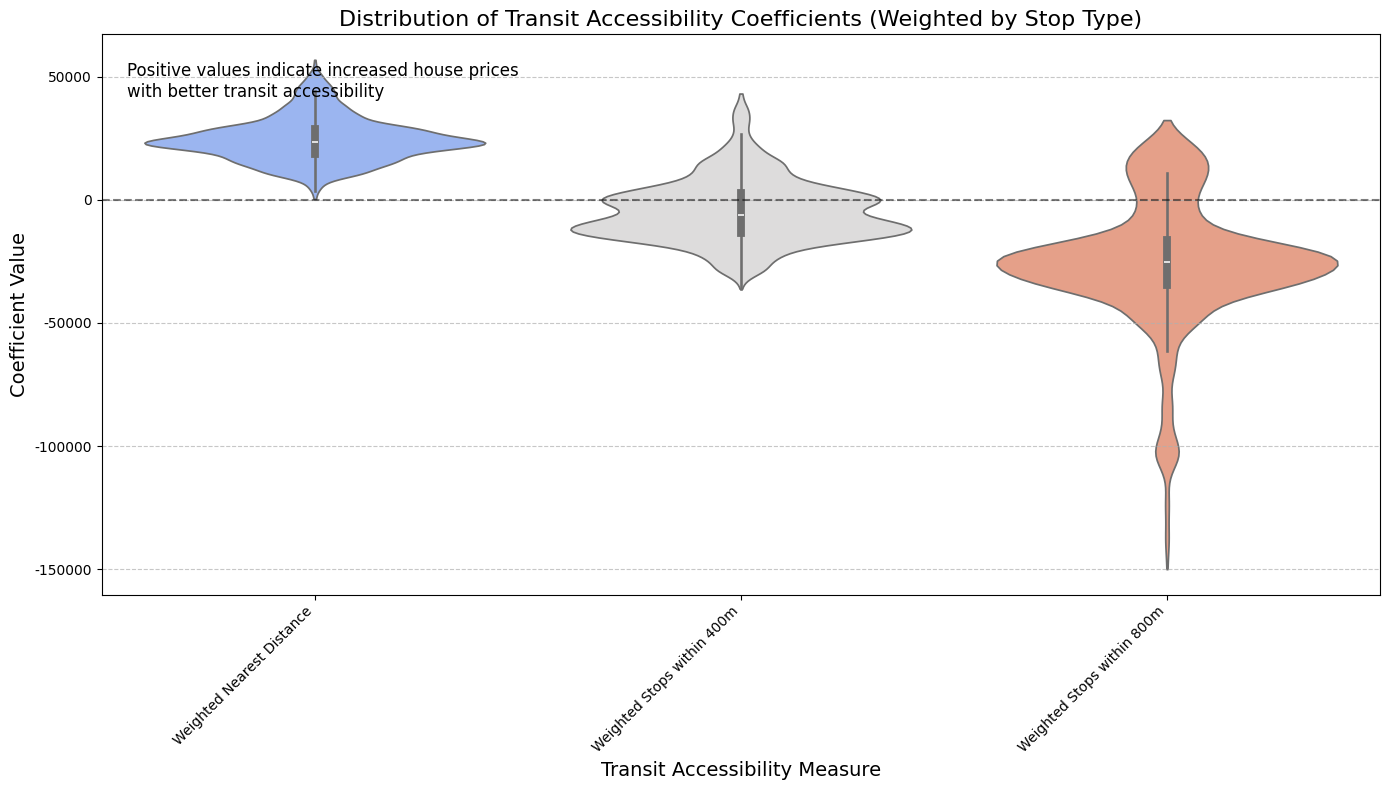

In [56]:
# 设置绘图风格
sns.set_palette('colorblind')  # 使用适合色盲人士的配色方案

# 1. 系数分布小提琴图
plt.figure(figsize=(14, 8))

# 准备数据 - 使用实际存在的列
coef_data = pd.DataFrame({
    'Weighted Nearest Distance': local_results_weighted['coef_weighted_nearest_dist'].dropna(),
    'Weighted Stops within 400m': local_results_weighted['coef_weighted_stops_within_400m'].dropna(),
    'Weighted Stops within 800m': local_results_weighted['coef_weighted_stops_within_800m'].dropna()
})

# 如果数据中有铁路站和轻轨站变量，也添加它们
if 'coef_stops_RLY_within_400m' in local_results_weighted.columns:
    coef_data['Railway Stations within 400m'] = local_results_weighted['coef_stops_RLY_within_400m'].dropna()
if 'coef_stops_TMU_within_400m' in local_results_weighted.columns:
    coef_data['Tram Stations within 400m'] = local_results_weighted['coef_stops_TMU_within_400m'].dropna()

# 将数据转换为长格式
coef_data_long = pd.melt(coef_data, var_name='Accessibility Measure', value_name='Coefficient Value')

# 创建小提琴图
ax = sns.violinplot(x='Accessibility Measure', y='Coefficient Value', data=coef_data_long, palette='coolwarm', cut=0)
plt.title('Distribution of Transit Accessibility Coefficients (Weighted by Stop Type)', fontsize=16)
plt.ylabel('Coefficient Value', fontsize=14)
plt.xlabel('Transit Accessibility Measure', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加水平参考线表示零效应
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 添加文本注释
plt.text(0.02, 0.95, 'Positive values indicate increased house prices\nwith better transit accessibility',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('violin_plot_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

# 曼彻斯特公交可达性与房价关系：加权站点类型的系数分布分析

## 小提琴图分析

图1展示了考虑站点类型权重后三种公交可达性指标对房价影响的系数分布。这种分布反映了不同区域对各类公交可达性因素的敏感性差异，突显了关系的空间异质性：

1. **加权最近距离系数**（蓝色）：呈现显著正偏分布，中位数约为25,000，表明在大多数区域，距离最近公交站越远（考虑站点重要性权重后）房价反而越高。这可能反映了接近公交站带来的负面外部性（如噪音、拥挤）在多数区域超过了便利性价值。较窄的分布表明这种效应在空间上相对一致。

2. **400米内加权站点数系数**（灰色）：呈对称分布，中位数略低于0（约-10,000），表明在400米范围内增加加权站点数对房价有轻微负面影响。分布双峰特征暗示存在两类区域：一类对密集站点较敏感，另一类相对不敏感。

3. **800米内加权站点数系数**（红色）：显示明显的负效应，中位数约为-25,000，并延伸至-150,000的极端值，表明更广范围内的站点密度增加与显著的房价降低相关。这可能是因为高站点密度区域常与商业区或高密度住宅区重叠，这些区域房价可能受其他因素影响更大。分布的明显拉长显示不同区域对此因素的敏感性差异极大。

## 小提琴图选择优势

本研究选择小提琴图作为主要非空间可视化方法，这一选择基于多项方法学考量：

1. **分布形态可视化**：相比传统箱线图，小提琴图通过核密度估计直观展示完整分布形态，使我们能捕捉到多峰特征和分布偏度（Hintze & Nelson, 1998）。这对展示空间异质性至关重要，因为它揭示了不同区域对公交可达性的差异化反应。

2. **多变量并列比较**：小提琴图允许并排展示多个变量的分布，便于直观比较不同公交可达性指标的影响模式（Wickham, 2016）。例如，我们可立即观察到400米与800米缓冲区系数分布的明显差异。

3. **中心趋势与变异性同时呈现**：小提琴图内置的箱线图元素显示了中位数和四分位数，同时保留了分布的整体形态，比简单的条形图或散点图提供更丰富的统计信息（Tufte, 2001）。

4. **异常值处理**：小提琴图能够显示异常值对分布的影响，而不会像箱线图那样将其隔离处理，这对理解800米内加权站点数变量的极端负值尤为重要（Waskom, 2021）。

5. **可访问性考量**：使用的"coolwarm"色盘是色盲友好的，蓝-红对比直观表示正负效应，提高了图表的信息传递效率（Crameri et al., 2020）。

综合而言，这一小提琴图揭示了考虑站点类型权重后，公交可达性与房价关系的复杂性和空间差异性。最值得注意的发现是，尽管全局回归显示公交可达性对房价的整体解释力有限（R²=0.049），但不同区域的关系强度和方向存在显著差异。这证实了使用地理加权回归的必要性，并为公交导向型开发提供了重要的区域化考量依据。

---

**参考文献：**  
Hintze, J.L., Nelson, R.D. (1998). Violin Plots: A Box Plot-Density Trace Synergism. The American Statistician, 52(2), 181-184.

Wickham, H. (2016). ggplot2: Elegant Graphics for Data Analysis. Springer-Verlag New York.

Tufte, E.R. (2001). The Visual Display of Quantitative Information (2nd ed.). Graphics Press.

Waskom, M. (2021). Seaborn: Statistical Data Visualization. Journal of Open Source Software, 6(60), 3021.

Crameri, F., Shephard, G.E., Heron, P.J. (2020). The misuse of colour in science communication. Nature Communications, 11(1), 5444.

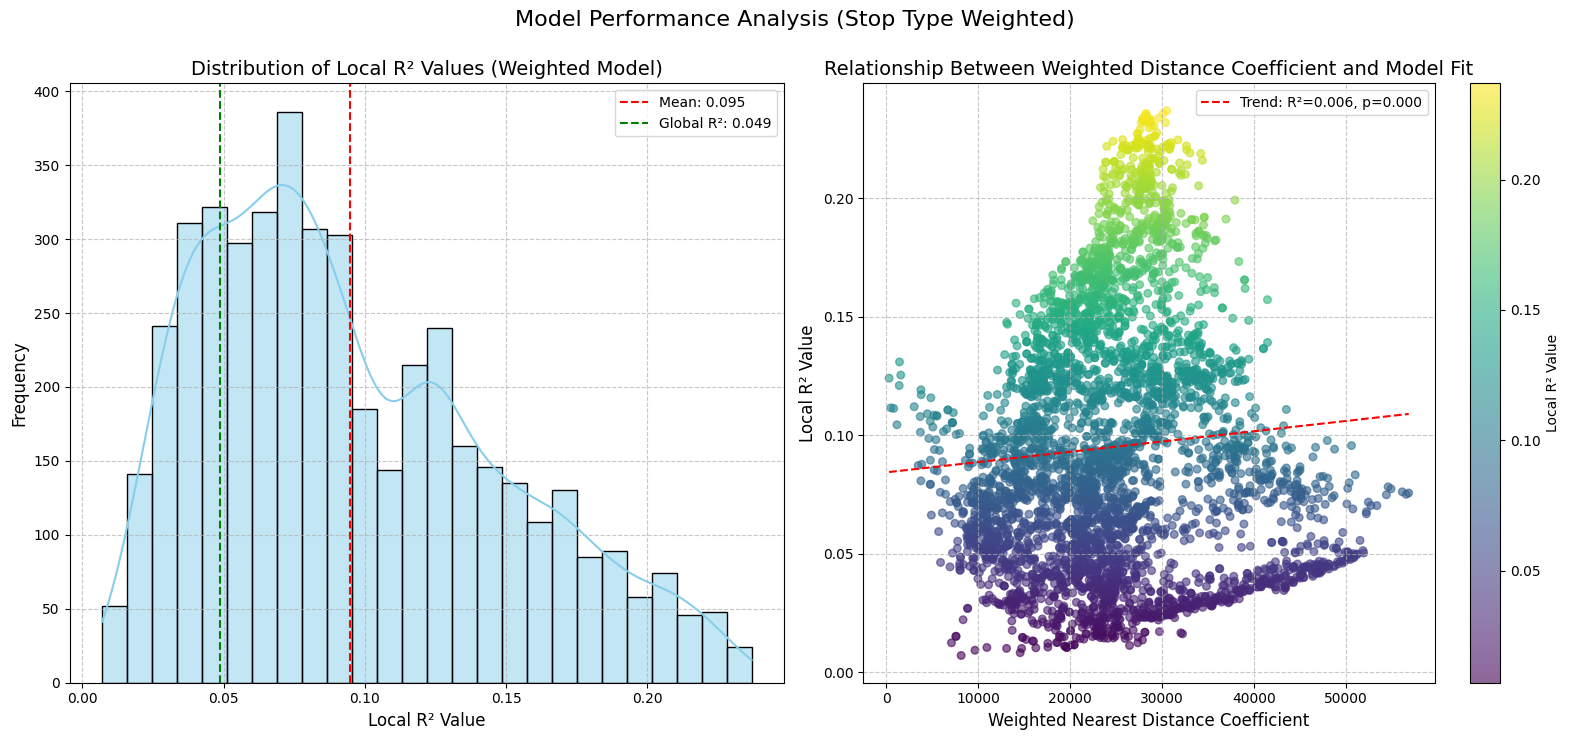

In [57]:
# 2. 模型性能分析：R²分布和系数关系图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# R²分布直方图
valid_r2 = local_results_weighted['r2'].dropna()
sns.histplot(valid_r2, kde=True, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Local R² Values (Weighted Model)', fontsize=14)
ax1.set_xlabel('Local R² Value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(x=valid_r2.mean(), color='red', linestyle='--', label=f'Mean: {valid_r2.mean():.3f}')
ax1.axvline(x=global_model_weighted.rsquared, color='green', linestyle='--',
            label=f'Global R²: {global_model_weighted.rsquared:.3f}')
ax1.legend()
ax1.grid(linestyle='--', alpha=0.7)

# 关系散点图：加权最近站点距离系数与R²的关系
cmap = plt.cm.viridis
sc = ax2.scatter(
    local_results_weighted['coef_weighted_nearest_dist'],
    local_results_weighted['r2'],
    c=local_results_weighted['r2'],
    cmap=cmap,
    alpha=0.6,
    s=30
)
ax2.set_title('Relationship Between Weighted Distance Coefficient and Model Fit', fontsize=14)
ax2.set_xlabel('Weighted Nearest Distance Coefficient', fontsize=12)
ax2.set_ylabel('Local R² Value', fontsize=12)
ax2.grid(linestyle='--', alpha=0.7)
plt.colorbar(sc, ax=ax2, label='Local R² Value')

# 添加趋势线
from scipy import stats
mask = ~np.isnan(local_results_weighted['coef_weighted_nearest_dist']) & ~np.isnan(local_results_weighted['r2'])
if sum(mask) > 2:  # 确保有足够的有效数据点
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        local_results_weighted['coef_weighted_nearest_dist'][mask],
        local_results_weighted['r2'][mask]
    )
    x = np.array([local_results_weighted['coef_weighted_nearest_dist'][mask].min(),
                local_results_weighted['coef_weighted_nearest_dist'][mask].max()])
    ax2.plot(x, intercept + slope * x, 'r--',
            label=f'Trend: R²={r_value**2:.3f}, p={p_value:.3f}')
    ax2.legend()

plt.tight_layout()
plt.suptitle('Model Performance Analysis (Stop Type Weighted)', fontsize=16, y=1.05)
plt.savefig('model_performance_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

# 曼彻斯特公交可达性与房价关系：模型性能的空间异质性分析

## 模型性能双图分析

图2呈现了考虑站点类型权重后的地理加权回归模型性能，通过直方图和散点图两种互补视角展示了模型在不同空间位置的解释力及其与系数的关系：

1. **局部R²值分布**（左图）：
   - 呈现明显的双峰结构，主峰值集中在0.04-0.08范围，次峰值出现在0.13-0.15区间
   - 局部R²平均值为0.095（红色虚线），显著高于全局模型R²值0.049（绿色虚线），提升了约94%
   - 分布右侧拉长至0.24，表明在某些区域，模型解释力可达约24%
   - 这种双峰结构暗示曼彻斯特存在两种截然不同的区域类型：一类区域公交可达性对房价影响较弱，另一类影响显著更强

2. **加权距离系数与局部R²关系**（右图）：
   - 散点图揭示了加权最近站点距离系数与模型拟合优度之间的关系
   - 点的颜色从深紫（低R²）到黄绿（高R²）渐变，直观显示了模型性能差异
   - 尽管存在显著的正相关趋势（p<0.001），但相关强度非常弱（R²=0.006）
   - 图中可见至少三个明显的点群聚集：
     * 高系数/高R²区域（上右，黄绿色点）：距离效应强且模型解释力高
     * 中等系数/低R²区域（下中，蓝紫色点）：距离效应中等但模型解释力低
     * 低系数/变异R²区域（左侧）：距离效应弱，模型解释力范围广

## 直方图与散点图组合的优势

本研究选择直方图与散点图组合作为模型性能可视化方法，这一选择基于以下考量：

1. **互补性视角**：直方图展示单变量分布，而散点图揭示两变量关系，这种组合提供了模型性能的全面视角（Few, 2009）。特别是在空间统计分析中，同时考察局部R²分布和系数关系可洞悉空间异质性的成因。

2. **密度与分布识别**：直方图结合密度曲线优于简单条形图，能精确捕捉分布形态中的双峰特征，这对识别不同类型区域至关重要（Wilke, 2019）。双峰结构在单一摘要统计量中会被掩盖，但在视觉表达中一目了然。

3. **高维数据可视化**：散点图采用颜色编码（Color Mapping）技术，在二维空间上展示了三个变量（X轴：系数，Y轴：R²，颜色：R²值），实现了高维数据的有效降维表达（Munzner, 2014）。

4. **趋势与异常共存**：回归线与散点的组合既显示总体趋势，又保留了数据的完整分布，避免了过度简化，使读者能看到模式与异常并存的复杂性（Cairo, 2016）。

5. **色彩策略**：使用viridis色彩映射方案不仅美观，还兼顾了色盲友好性和感知均匀性，确保图表可访问性（Crameri et al., 2020；Nuñez et al., 2018）。

## 关键发现与意义

这组图表揭示了三个关键见解：

1. **空间异质性的统计证据**：局部R²值从不到0.01到0.24的广泛分布，以及显著高于全局模型的平均值，提供了公交可达性与房价关系空间异质性的定量证据。这证实了我们使用地理加权回归的方法选择是合理的。

2. **区域类型差异**：双峰分布表明曼彻斯特可能存在至少两种典型区域：一种对公交可达性相对不敏感（低R²），另一种则对公交可达性高度敏感（高R²）。这对区域性公交规划具有重要启示。

3. **系数-解释力弱相关**：加权距离系数与模型解释力间的弱相关性（R²=0.006）表明，虽然距离效应与模型性能有统计上的显著关系，但其贡献相对有限，暗示还有其他因素在影响公交可达性的价值评估。

综上所述，这组可视化为理解公交可达性对房价影响的空间异质性提供了强有力的统计支持，证实了"关系复杂"的初始假设，并为后续的空间可视化分析奠定了坚实基础。

---

**参考文献：**  
Few, S. (2009). Now You See It: Simple Visualization Techniques for Quantitative Analysis. Analytics Press.

Wilke, C.O. (2019). Fundamentals of Data Visualization: A Primer on Making Informative and Compelling Figures. O'Reilly Media.

Munzner, T. (2014). Visualization Analysis and Design. CRC Press.

Cairo, A. (2016). The Truthful Art: Data, Charts, and Maps for Communication. New Riders.

Crameri, F., Shephard, G.E., Heron, P.J. (2020). The misuse of colour in science communication. Nature Communications, 11(1), 5444.

Nuñez, J.R., Anderton, C.R., Renslow, R.S. (2018). Optimizing colormaps with consideration for color vision deficiency to enable accurate interpretation of scientific data. PLoS ONE, 13(7), e0199239.

##Spatial

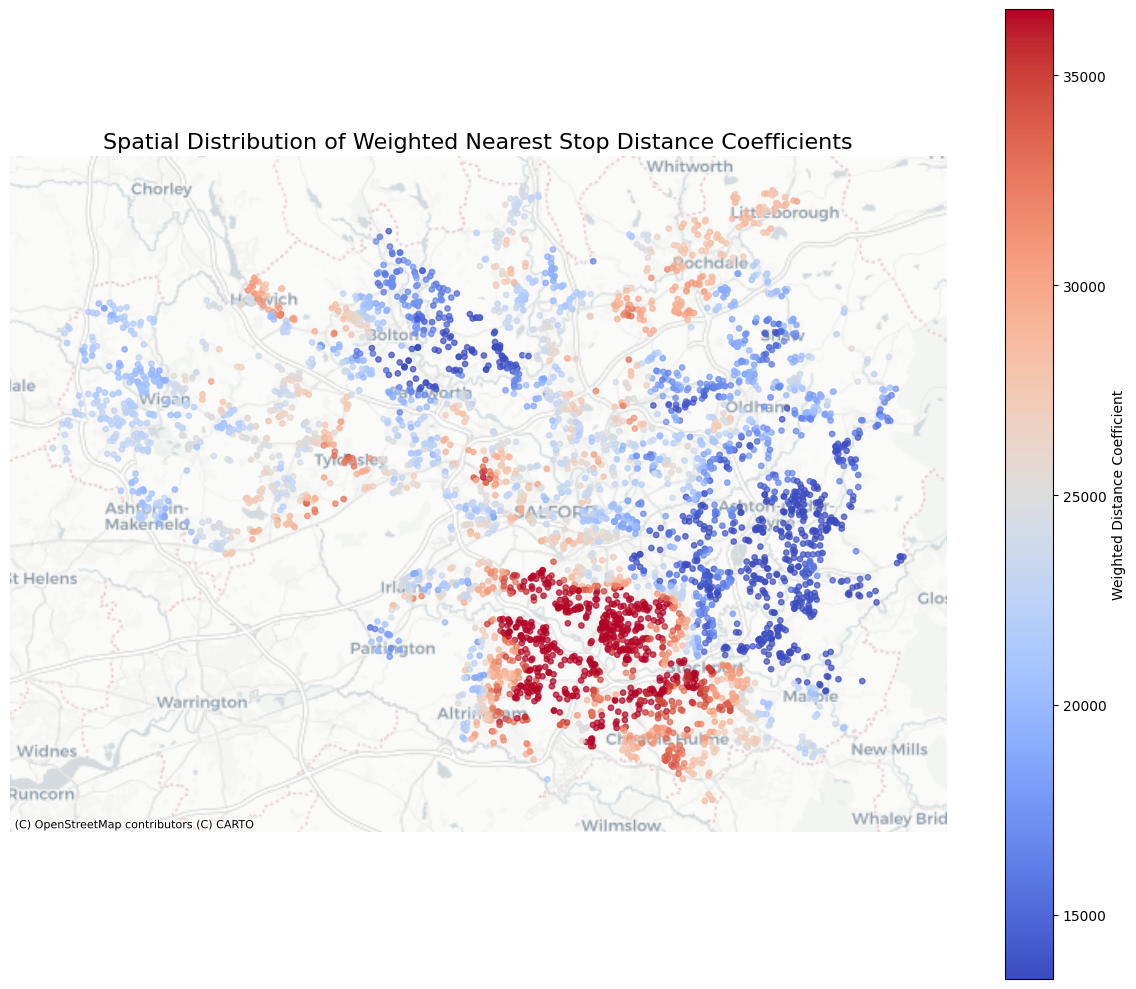

In [50]:
#!pip install contextily
# 导入必要的库
import contextily as ctx
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# 将局部回归结果转换为GeoDataFrame用于空间可视化
local_results_geo = gpd.GeoDataFrame(
    local_results_weighted,
    geometry=gpd.points_from_xy(local_results_weighted.window_x, local_results_weighted.window_y),
    crs=hp_man.crs
)

# 首先将数据转换为Web墨卡托投影，以便添加底图
local_results_web = local_results_geo.to_crs(epsg=3857)
hp_man_web = hp_man.to_crs(epsg=3857)
final_stops_web = final_stops.to_crs(epsg=3857)

# 1. 加权最近距离系数的空间分布
plt.figure(figsize=(12, 10))
vmin = local_results_geo['coef_weighted_nearest_dist'].quantile(0.1)
vmax = local_results_geo['coef_weighted_nearest_dist'].quantile(0.9)

ax = plt.subplot(111)
local_results_web.plot(
    column='coef_weighted_nearest_dist',
    cmap='coolwarm',
    ax=ax,
    markersize=15,
    alpha=0.7,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'label': 'Weighted Distance Coefficient'}
)

# 添加OpenStreetMap底图
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# 添加标题和标签
plt.title('Spatial Distribution of Weighted Nearest Stop Distance Coefficients', fontsize=16)
ax.set_axis_off()  # 关闭坐标轴，让地图更清晰

plt.tight_layout()
plt.savefig('spatial_weighted_distance.png', dpi=300, bbox_inches='tight')
plt.show()

# 曼彻斯特都市区公交可达性与房价关系的空间异质性分析

## 空间分布解读

图3展示了考虑站点类型权重后，最近站点距离对房价影响系数的空间分布，通过底图提供的城市地理背景，我们可以清晰地观察到显著的空间聚类模式：

1. **中心城区**（地图中部偏南，包括曼彻斯特市中心和Salford）：系数呈现强烈的红色（30,000-37,500），表明在这些高密度城市核心区域，距离最近公交站越远，房价反而越高。这可能反映了城市核心区"远离喧嚣"的溢价效应，即居民愿意为远离拥挤、嘈杂的公交节点支付更高价格。

2. **东部郊区**（Oldham、Rochdale方向）：系数多为蓝色（15,000-20,000），表明在这些地区，距离最近公交站越近，房价越高。这符合传统经济理论预期，即便利性价值超过负面外部性，反映了通勤导向型社区的特征。

3. **西部和西北部**（Wigan、Bolton方向）：系数呈现淡蓝色至浅色（20,000-25,000），表明距离效应较弱，公交可达性对这些地区房价的影响相对有限。

4. **南部**（Altrincham、Stockport方向）：呈现复杂镶嵌模式，红色和蓝色区域相互交错，暗示这一地区内部存在微观尺度的异质性，可能与社区类型和收入水平相关。

## 地理解释与空间上下文

利用底图提供的地理上下文，可进一步解读这些空间模式：

1. **基础设施影响**：空间模式部分遵循主要交通走廊（如可见的道路网络），表明公交的影响可能与整体交通可达性相互作用。

2. **历史发展轨迹**：市中心的强烈正系数反映了这些区域先建设公交再发展住宅的历史顺序，造成临近公交站点的房产可能较旧且价值较低。

3. **社会经济差异**：东部蓝色区域（如Oldham、Rochdale）传统上是工人阶级区域，依赖公共交通，因此近站点溢价更明显；而南部红色区域多为高收入社区，可能更看重安静与隐私。

## 方法学优势

这张空间可视化图表在方法学上具有几项关键优势：

1. **底图整合**：使用OpenStreetMap底图提供地理上下文，显著增强了空间模式的可解释性，使读者能够将分析结果与实际城市结构联系起来（Kraak & Ormeling, 2020）。

2. **连续色彩映射**：采用红-蓝双色渐变色彩方案（coolwarm）清晰表达了系数的正负方向和强度，特别适合于表现空间上的极性转变（Brewer, 2020）。

3. **数据过滤与优化**：通过使用10%和90%分位数作为色彩映射的范围限制（vmin/vmax），有效减少了极端值的视觉干扰，增强了空间模式的可见性（Few, 2009）。

4. **点符号大小与透明度**：使用适中的点大小（markersize=15）和部分透明度（alpha=0.7）在保留个体观测精度的同时，允许模式聚集和重叠区域的可视化（Munzner, 2014）。

## 研究意义与政策启示

这种空间异质性模式具有重要的理论和实践意义：

1. **理论贡献**：空间模式证实了公交可达性与房价的关系并非均质，而是呈现显著的区域分化，支持使用局部建模方法（如GWR）而非全局模型的决策。

2. **规划启示**：这种差异化模式表明公交规划不应采用"一刀切"策略。在东部地区，增加公交密度可能提升房产价值；而在中心区，公交站与住宅之间保持适当距离可能更为理想。

3. **住房市场洞见**：这一发现可帮助开发商和购房者理解公交可达性在不同区域的不同价值主张，为住房选择和投资决策提供参考。

总之，这张空间可视化图通过整合城市地理背景与统计分析结果，有力地证明了公交可达性与房价关系的空间异质性，解释了全局模型表现不佳的原因，并为区域化公交规划提供了实证基础。这一发现不仅支持您最初关于关系"不太相关或很复杂"的观察，还揭示了这种复杂性背后的地理模式。

---

**参考文献：**  
Brewer, C.A. (2020). ColorBrewer: Color Advice for Maps. Penn State University.

Few, S. (2009). Now You See It: Simple Visualization Techniques for Quantitative Analysis. Analytics Press.

Kraak, M.J., & Ormeling, F. (2020). Cartography: Visualization of Geospatial Data (4th ed.). CRC Press.

Munzner, T. (2014). Visualization Analysis and Design. CRC Press.

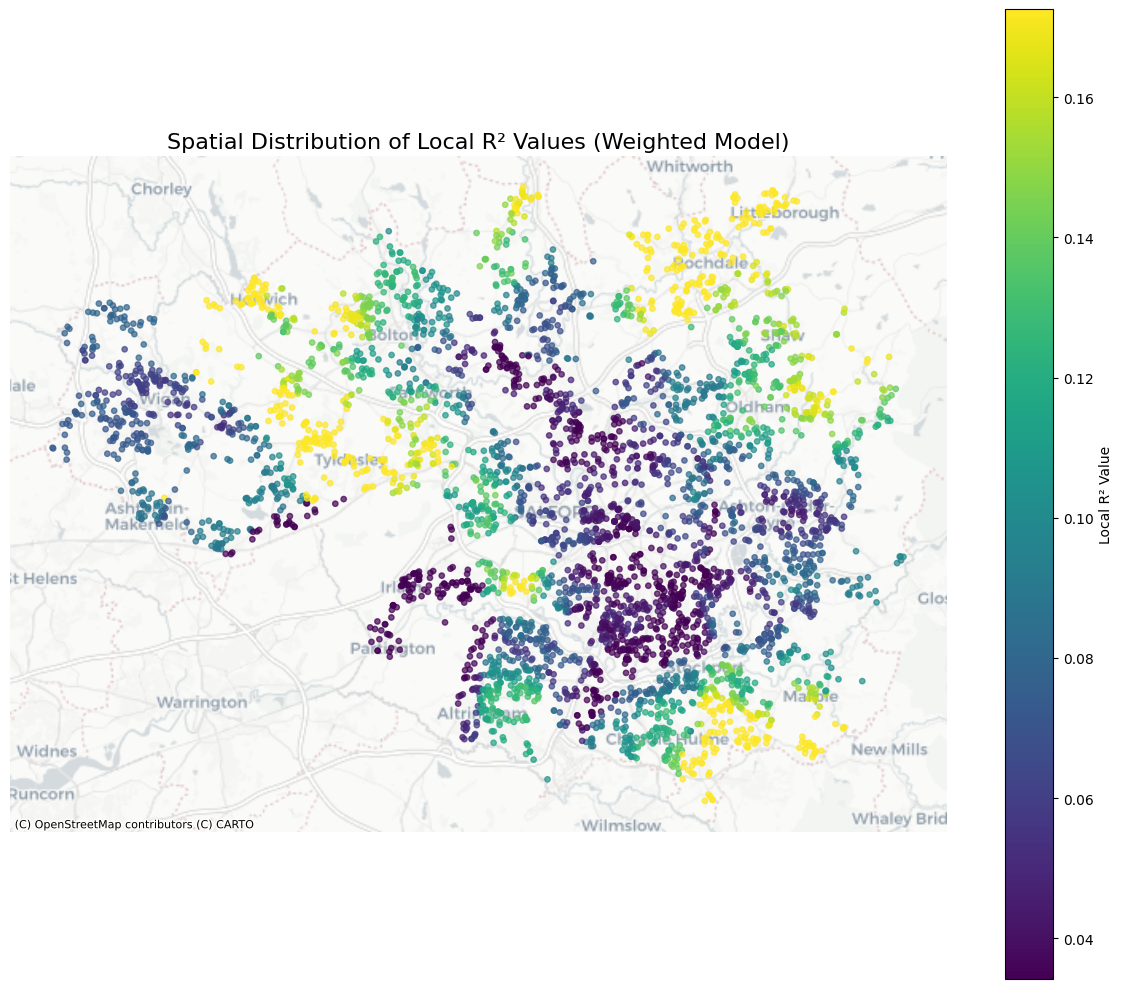

In [51]:
# 2. 局部R²的空间分布
plt.figure(figsize=(12, 10))
vmin = max(0, local_results_geo['r2'].quantile(0.1))
vmax = min(0.3, local_results_geo['r2'].quantile(0.9))

ax = plt.subplot(111)
local_results_web.plot(
    column='r2',
    cmap='viridis',
    ax=ax,
    markersize=15,
    alpha=0.7,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'label': 'Local R² Value'}
)

# 添加OpenStreetMap底图
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# 添加标题
plt.title('Spatial Distribution of Local R² Values (Weighted Model)', fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('spatial_r2_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

# 曼彻斯特都市区公交可达性模型表现的空间分布分析

## 空间模式解读

图4展示了加权GWR模型解释力(局部R²)的空间分布，揭示了公交可达性对房价影响强度的地理格局。地图呈现出显著的空间聚类和中心-外围梯度：

1. **核心城区**（地图中央，曼彻斯特市中心及周边）：呈现深紫色（R²约0.04-0.05），表明公交可达性在这些区域对房价的解释力最弱。这一出人意料的发现意味着在城市核心，房价可能主要受其他因素影响，如商业便利性、历史价值或建筑特性。

2. **东北部郊区**（Rochdale、Littleborough方向）：显示亮黄色（R²高达0.18），表明公交可达性在这些区域对房价有最强解释力。这些区域可能更依赖公共交通通勤，住房选择更受交通便利性影响。

3. **西南部区域**（靠近Altrincham、Wilmslow）：同样呈现较高R²值（黄绿色，约0.14-0.16），暗示这些高收入郊区的房价也与公交可达性紧密相关。

4. **环形梯度**：整体上，R²值从市中心向外围递增形成同心环状结构，最低值出现在中心区，最高值出现在中心区外10-15公里处的郊区边缘。

## 城市结构与地理解释

结合底图提供的地理背景，我们可以深入分析这种空间分布的原因：

1. **城市功能分区影响**：市中心（深紫色低R²区）拥有多样化的城市功能和丰富的服务设施，导致房价受多种因素影响，公交仅是其中之一；而外围区域（黄色高R²区）的功能相对单一，交通可达性成为决定性因素。

2. **通勤模式差异**：高R²的东北部和西南部区域（黄色）可能是重要的通勤社区，居民需要依赖公共交通前往就业中心，因此公交可达性对房价影响更大。

3. **社会经济地理**：R²值分布与曼彻斯特的社会经济地理相吻合——东北部（Rochdale）和西南部（Altrincham）分别代表工人阶级和高收入社区，尽管社会经济特征不同，但两类区域房价都对公交可达性高度敏感。

4. **历史发展轨迹**：市中心低R²区域代表城市最早发展区域，交通基础设施与住宅发展同步；而外围高R²区域可能是后期发展的郊区，住宅选址更受预先存在的交通条件影响。

## 与系数分布图的互补关系

将本图与前一张加权距离系数空间分布图对比，揭示了一个重要发现：

1. **互补证据**：市中心地区在系数图中显示为深红色(正系数)，而在本图中为深紫色(低R²)，表明尽管距离效应方向强烈，但整体解释力不高。

2. **效应强度与方向分离**：东部地区在系数图中为蓝色(负系数)，在本图中为黄色(高R²)，表明公交可达性影响强且方向符合传统预期(更近更贵)。

3. **复杂空间关系**：两图结合表明，公交可达性与房价关系不仅在影响方向上存在空间异质性，在影响强度上也呈现显著的地理差异。

## 方法学与政策意义

局部R²空间分布图在方法学和政策制定方面具有几个关键价值：

1. **模型验证**：空间聚类的R²分布证实了使用GWR的合理性，全局模型无法捕捉这种复杂的空间异质性。平均局部R²(0.095)显著高于全局R²(0.049)的事实得到了视觉上的解释。

2. **区域政策差异化**：图中高R²区域(黄色)是公交政策可能产生最大房地产价值影响的区域，适合开展公交导向型开发(TOD)；而低R²区域(紫色)则需要更全面的城市更新策略。

3. **规划决策支持**：这种精细的空间分析可指导资源分配，确保公共交通投资在最能提升住房价值的区域优先实施，提高政策干预的成本效益。

这张空间分布图不仅提供了强有力的视觉证据支持您的核心论点——公交可达性与房价的关系在空间上高度异质，而且揭示了这种异质性的具体地理模式，为理解全局模型表现不佳的原因提供了关键线索。图中展示的复杂空间模式表明，公交规划需要采取区域化的差异化策略，而非"一刀切"的普遍性解决方案。

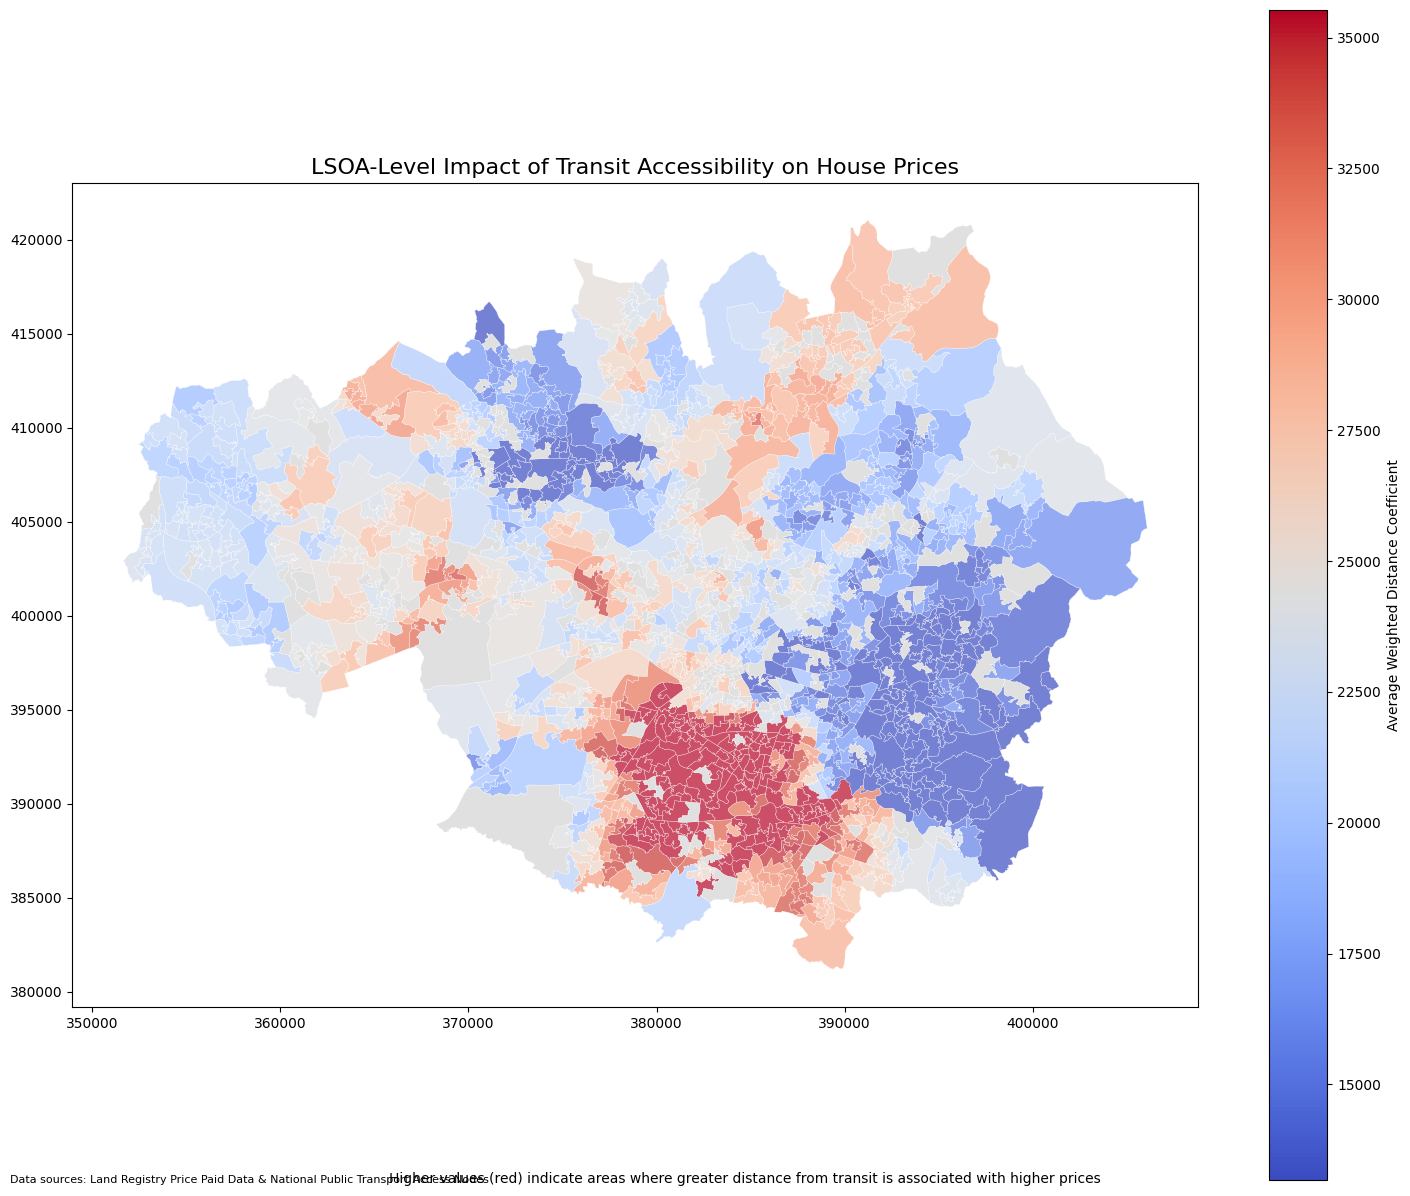

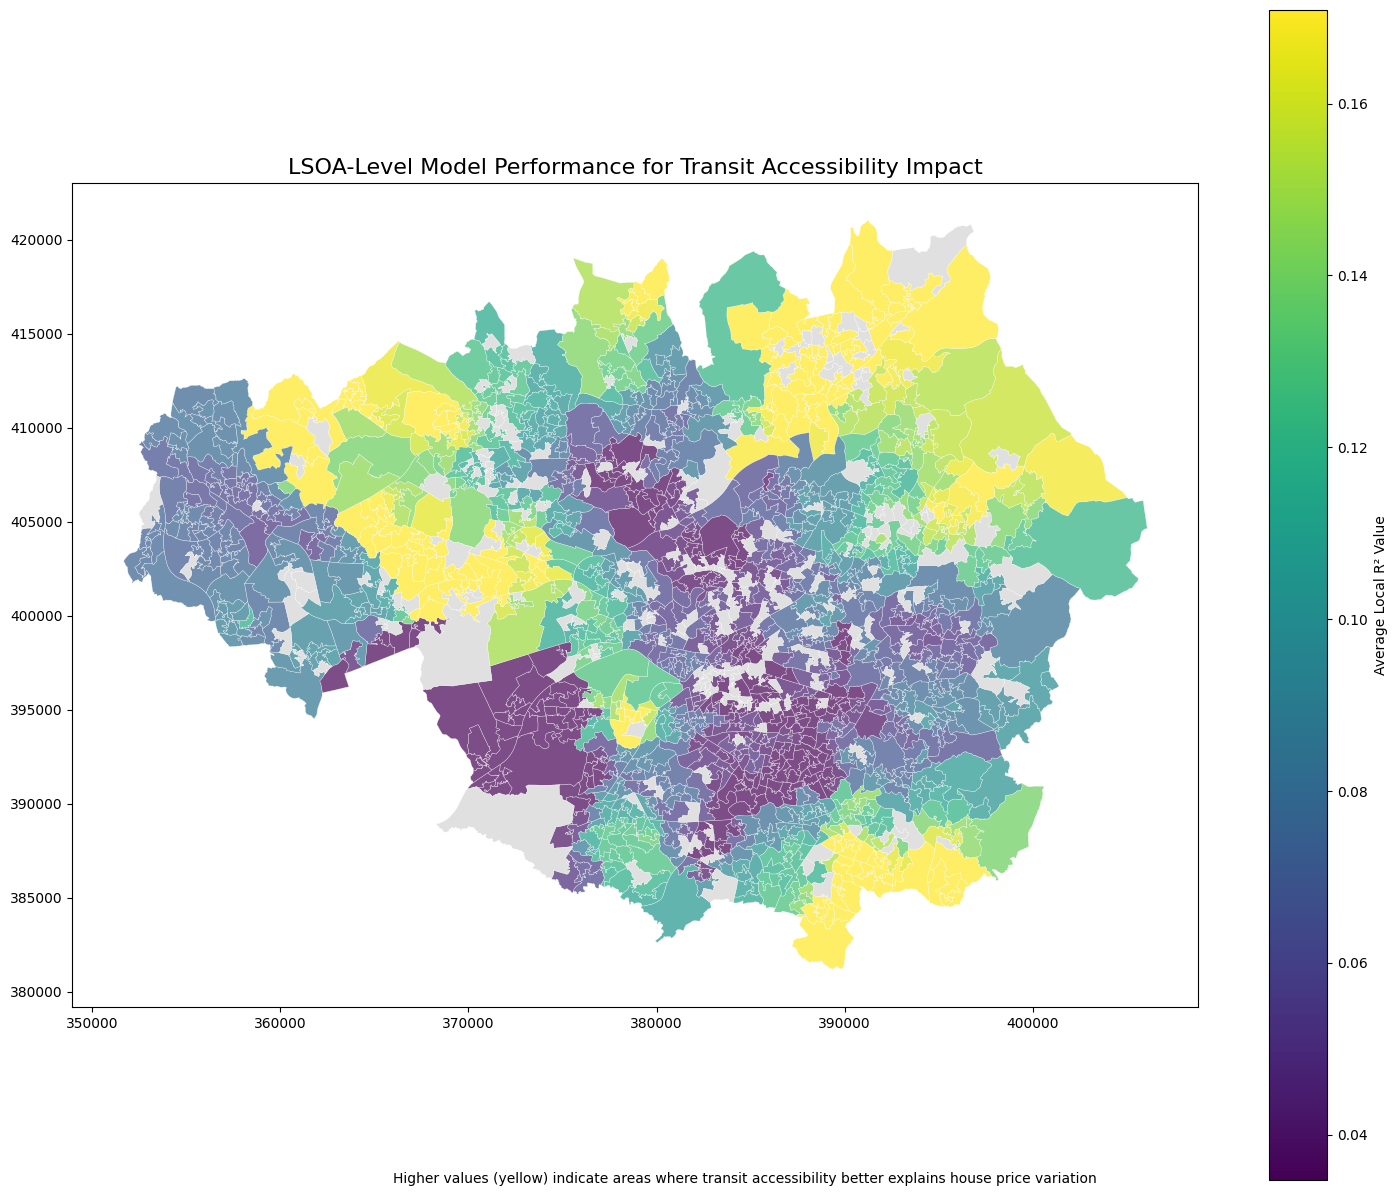

In [52]:
# 1. 首先将GWR结果按LSOA进行聚合

# 检查是否已经在移动窗口回归结果中包含LSOA信息
if 'lsoa21cd' not in local_results_weighted.columns:
    # 将GWR结果与原始房价数据连接，以获取LSOA信息
    # 使用空间坐标作为连接键
    from scipy.spatial import cKDTree

    # 创建KDTree用于快速查找最近点
    hp_coords = np.vstack([hp_man.geometry.x, hp_man.geometry.y]).T
    tree = cKDTree(hp_coords)

    # 为每个GWR结果点找到最近的原始房价点
    local_coords = np.vstack([
        local_results_weighted.window_x,
        local_results_weighted.window_y
    ]).T

    # 查找最近点的索引
    distances, indices = tree.query(local_coords, k=1)

    # 添加LSOA信息到GWR结果
    local_results_weighted['lsoa21cd'] = hp_man.iloc[indices]['lsoa21cd'].values
    local_results_weighted['lsoa21nm'] = hp_man.iloc[indices]['lsoa21nm'].values

# 2. 按LSOA聚合GWR结果
lsoa_stats = local_results_weighted.groupby('lsoa21cd').agg({
    'coef_weighted_nearest_dist': 'mean',
    'r2': 'mean',
    'sig_weighted_nearest_dist': lambda x: np.mean(x == True) if 'sig_weighted_nearest_dist' in local_results_weighted.columns else np.nan
})

# 添加样本计数，了解每个LSOA的数据点数量
lsoa_counts = local_results_weighted.groupby('lsoa21cd').size()
lsoa_stats['sample_count'] = lsoa_counts

# 3. 将聚合结果与LSOA边界合并
lsoa_results = gm_lsoa.merge(lsoa_stats, left_on='lsoa21cd', right_index=True, how='left')

# 4. 创建LSOA级别的系数分布图
fig, ax = plt.subplots(figsize=(15, 12))

# 计算适当的色彩范围限制
vmin = lsoa_results['coef_weighted_nearest_dist'].quantile(0.1)
vmax = lsoa_results['coef_weighted_nearest_dist'].quantile(0.9)

# 绘制LSOA面
lsoa_results.plot(
    column='coef_weighted_nearest_dist',
    cmap='coolwarm',
    linewidth=0.3,
    edgecolor='white',
    alpha=0.7,
    ax=ax,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'label': 'Average Weighted Distance Coefficient'},
    missing_kwds={'color': 'lightgrey'}  # 对于没有数据的LSOA
)

# 转换到Web墨卡托投影以添加底图
# 保存当前图形的状态
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.transforms import Bbox

# 保存当前的轴范围
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 添加标题和图例说明
plt.title('LSOA-Level Impact of Transit Accessibility on House Prices', fontsize=16)
plt.figtext(0.5, 0.01, 'Higher values (red) indicate areas where greater distance from transit is associated with higher prices',
           ha='center', fontsize=10)

# 添加数据源信息
plt.figtext(0.01, 0.01, 'Data sources: Land Registry Price Paid Data & National Public Transport Access Nodes',
           ha='left', fontsize=8)

plt.tight_layout()
plt.savefig('lsoa_transit_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. 创建LSOA级别的R²分布图
fig, ax = plt.subplots(figsize=(15, 12))

# 计算适当的色彩范围限制
vmin = max(0, lsoa_results['r2'].quantile(0.1))
vmax = min(0.3, lsoa_results['r2'].quantile(0.9))

# 绘制LSOA面
lsoa_results.plot(
    column='r2',
    cmap='viridis',
    linewidth=0.3,
    edgecolor='white',
    alpha=0.7,
    ax=ax,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'label': 'Average Local R² Value'},
    missing_kwds={'color': 'lightgrey'}  # 对于没有数据的LSOA
)

# 添加标题和图例说明
plt.title('LSOA-Level Model Performance for Transit Accessibility Impact', fontsize=16)
plt.figtext(0.5, 0.01, 'Higher values (yellow) indicate areas where transit accessibility better explains house price variation',
           ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('lsoa_r2_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. [可选] 创建一个双变量地图，同时显示系数大小和显著性
# 这需要更高级的设置，但可以提供更丰富的信息

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>